# Kittens

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

In [1]:
# import functions from modsim

from modsim import *

If you have used the Internet, you have probably seen videos of kittens unrolling toilet paper.
And you might have wondered how long it would take a standard kitten to unroll 47 m of paper, the length of a standard roll.

The interactions of the kitten and the paper rolls are complex.  To keep things simple, let's assume that the kitten pulls down on the free end of the roll with constant force.  And let's neglect the friction between the roll and the axle.

This diagram shows the paper roll with the force applied by the kitten, $F$, the lever arm of the force around the axis of rotation, $r$, and the resulting torque, $\tau$.

![Diagram of a roll of toilet paper, showing a force, lever arm, and the resulting torque.](https://github.com/AllenDowney/ModSim/raw/main/figs/kitten.png)

Assuming that the force applied by the kitten is 0.002 N, how long would it take to unroll a standard roll of toilet paper?

We'll use the same parameters as in Chapter 24:

In [2]:
Rmin = 0.02      # m
Rmax = 0.055     # m
Mcore = 15e-3    # kg
Mroll = 215e-3   # kg
L = 47           # m
tension = 0.002  # N

`Rmin` and `Rmax` are the minimum and maximum radius of the roll, respectively.
`Mcore` is the weight of the core (the cardboard tube at the center) and `Mroll` is the total weight of the paper.
`L` is the unrolled length of the paper.
`tension` is the force the kitten applies by pulling on the loose end of the roll (I chose this value because it yields reasonable results).

In Chapter 24 we defined $k$ to be the constant that relates a change in the radius of the roll to a change in the rotation of the roll:

$$dr = k~d\theta$$ 

And we derived the equation for $k$ in terms of $R_{min}$, $R_{max}$, and $L$. 

$$k =  \frac{1}{2L} (R_{max}^2 - R_{min}^2)$$

So we can compute `k` like this:

In [3]:
k = (Rmax**2 - Rmin**2) / 2 / L    
k    

2.7925531914893616e-05

## Moment of Inertia

To compute angular acceleration, we'll need the moment of inertia for the roll.

At <http://modsimpy.com/moment> you can find moments of inertia for
simple geometric shapes. I'll model the core as a "thin cylindrical shell", and the paper roll as a "thick-walled cylindrical tube with open ends".

The moment of inertia for a thin shell is just $m r^2$, where $m$ is the mass and $r$ is the radius of the shell.

For a thick-walled tube the moment of inertia is

$$I = \frac{\pi \rho h}{2} (r_2^4 - r_1^4)$$ 

where $\rho$ is the density of the material, $h$ is the height of the tube (if we think of the roll oriented vertically), $r_2$ is the outer diameter, and $r_1$ is the inner diameter.

Since the outer diameter changes as the kitten unrolls the paper, we
have to compute the moment of inertia, at each point in time, as a
function of the current radius, `r`, like this:

In [4]:
def moment_of_inertia(r):
    """Moment of inertia for a roll of toilet paper.
    
    r: current radius of roll in meters
    
    returns: moment of inertia in kg m**2
    """    
    Icore = Mcore * Rmin**2   
    Iroll = np.pi * rho_h / 2 * (r**4 - Rmin**4)
    return Icore + Iroll

`Icore` is the moment of inertia of the core; `Iroll` is the moment of inertia of the paper.

`rho_h` is the density of the paper in terms of mass per unit of area. 
To compute `rho_h`, we compute the area of the complete roll like this:

In [5]:
area = np.pi * (Rmax**2 - Rmin**2)
area

0.008246680715673206

And divide the mass of the roll by that area.

In [6]:
rho_h = Mroll / area
rho_h

26.07109543981524

As an example, here's the moment of inertia for the complete roll.

In [28]:
moment_of_inertia(Rmax)

0.00037418750000000006

As `r` decreases, so does `I`.  Here's the moment of inertia when the roll is empty.

In [29]:
moment_of_inertia(Rmin)

6e-06

The way $I$ changes over time might be more of a problem than I have made it seem.  In the same way that $F = m a$ only applies when $m$ is constant, $\tau = I \alpha$ only applies when $I$ is constant.  When $I$ varies, we usually have to use a more general version of Newton's law.  However, I believe that in this example, mass and moment of inertia vary together in a way that makes the simple approach work out.

A friend of mine who is a physicist is not convinced; nevertheless, let's proceed on the assumption that I am right.

## Simulation

The state variables we'll use are

* `theta`, the total rotation of the roll in radians, 

* `omega`, angular velocity in rad / s,

* `r`, the radius of the roll, and

* `y`, the length of the unrolled paper.

Here's a `State` object with the initial conditions.

In [9]:
init = State(theta=0, omega=0, y=0, r=Rmax)
init

theta    0.000
omega    0.000
y        0.000
r        0.055
Name: state, dtype: float64

And here's a `System` object with the starting conditions and `t_end`.

In [16]:
system = System(init=init, t_end=120)
system

namespace(init=theta    0.000
               omega    0.000
               y        0.000
               r        0.055
               Name: state, dtype: float64,
          t_end=120)

You can take it from here.

**Exercise:**

Write a slope function we can use to simulate this system.  Test it with the initial conditions.  The results should be approximately

```
0.0, 0.294, 0.0, 0.0
```


In [48]:
# Solution goes here
def slope_func(t, state, sysem):
    theta, omega, y, r = state
    
    I = moment_of_inertia(r)
    alpha = tension * r / I
    dydt = r * omega
    drdt = - k * omega
    return omega, alpha, dydt, drdt


In [49]:
# Solution goes here
slope_func(0, init, system)

(0.0, 0.2939702689159846, 0.0, -0.0)

**Exercise:** Write an event function that stops the simulation when `y` equals `L`, that is, when the entire roll is unrolled.  Test your function with the initial conditions.

In [50]:
# Solution goes here
def event_func(t, state, system):
    theta, omega, y, r = state
    return y - L

In [51]:
# Solution goes here
event_func(0, init, system)

-47.0

Now run the simulation.

In [52]:
# Solution goes here
results, details = run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

And check the results.

In [53]:
results.tail()

,theta,omega,y,r
73.117672,1086.744892,48.329143,43.280738,0.024652
73.879314,1124.582020,51.090051,44.193502,0.023595
74.640957,1164.679317,54.287475,45.117188,0.022476
75.402599,1207.425047,58.065956,46.052385,0.021282
76.164241,1253.335715,62.640778,47.000000,0.020000


The final value of `theta` should be about 200 rotations, the same as in Chapter 24.

The final value of `omega` should be about 63 rad/s, which is about 10 revolutions per second.  That's pretty fast, but it might be plausible.

The final value of `y` should be `L`, which is 47 m.

The final value of `r` should be `Rmin`, which is 0.02 m.

And the total unrolling time should be about 76 seconds, which seems plausible.

The following cells plot the results.

`theta` increases slowly at first, then accelerates.

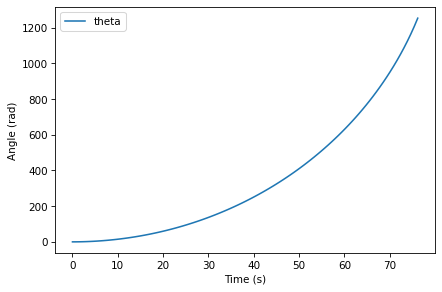

In [54]:
results.theta.plot(color='C0', label='theta')
decorate(xlabel='Time (s)',
         ylabel='Angle (rad)')

Angular velocity, `omega`, increases almost linearly at first, as constant force yields almost constant torque.  Then, as the radius decreases, the lever arm decreases, yielding lower torque, but moment of inertia decreases even more, yielding higher angular acceleration.

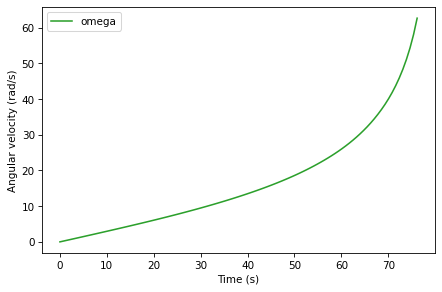

In [55]:
results.omega.plot(color='C2', label='omega')

decorate(xlabel='Time (s)',
         ylabel='Angular velocity (rad/s)')

`y` increases slowly and then accelerates.

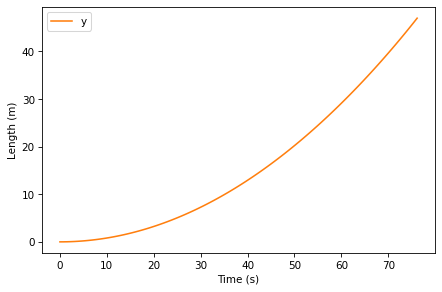

In [56]:
results.y.plot(color='C1', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (m)')

`r` decreases slowly, then accelerates.

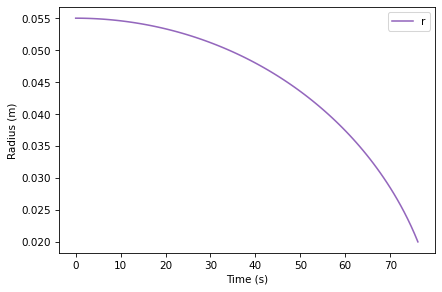

In [57]:
results.r.plot(color='C4', label='r')

decorate(xlabel='Time (s)',
         ylabel='Radius (m)')